In [85]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time

# Set seed
torch.manual_seed(0)

In [86]:
from preprocessing import load_data, preprocess_data, compute_hft_indicators

data_path = "AAPL_data/AAPL_2024-10-02_xnas-itch.parquet"
data = load_data(data_path)
data = preprocess_data(data)
data_hft = compute_hft_indicators(data)

data_hft.head()

,mid_price_high,mid_price_low,mid_price_close,mid_price_open,Returns,Target,add_ask_size,add_bid_size,cancel_ask_size,cancel_bid_size,...,EMA_5,MA_5,Bollinger_Upper,Bollinger_Lower,DMP_3,DMN_3,OLL3,OLL5,STOCHk_7_3_3,STOCHd_7_3_3
ts_event,,,,,,,,,,,,,,,,,,,,,
2024-10-02 04:00:07-04:00,225.720,225.720,225.720,225.720,0.000000,0.0,110.0,102.0,0.0,0.0,...,225.720329,225.719,225.723472,225.714528,0.0,0.00,0.000,0.005,94.444444,94.444444
2024-10-02 04:00:08-04:00,225.720,225.720,225.720,225.720,0.000000,0.0,1009.0,2003.0,0.0,1000.0,...,225.720219,225.720,225.720000,225.720000,0.0,0.00,0.000,0.000,94.444444,94.444444
2024-10-02 04:00:09-04:00,225.720,225.700,225.710,225.720,-0.000044,-1.0,3626.0,3500.0,2200.0,1300.0,...,225.716813,225.718,225.726944,225.709056,0.0,0.02,0.020,0.020,33.333333,74.074074
2024-10-02 04:00:10-04:00,225.720,225.710,225.715,225.710,0.000022,1.0,2400.0,0.0,1400.0,0.0,...,225.716209,225.717,225.725944,225.708056,0.0,0.02,0.010,0.010,50.000000,59.259259
2024-10-02 04:00:11-04:00,225.715,225.715,225.715,225.715,0.000000,0.0,5.0,0.0,0.0,0.0,...,225.715806,225.716,225.724367,225.707633,0.0,0.02,0.015,0.015,75.000000,52.777778


In [ ]:
features = ['add_ask_size', 'add_bid_size', 'cancel_ask_size', 'cancel_bid_size',
            'trade_ask_size', 'trade_bid_size', 'EMA_5', 'MA_5', 'DMP_3', 'DMN_3', 
            'OLL3', 'OLL5', 'STOCHk_7_3_3', 'STOCHd_7_3_3', 'Returns']

# Features that require StandardScaler (price-dependent and volume-based)
standard_features = ['add_ask_size', 'add_bid_size', 'cancel_ask_size', 'cancel_bid_size',
                     'trade_ask_size', 'trade_bid_size', 'EMA_5', 'MA_5', 'Returns']

# Features that require MinMaxScaler (bounded indicators)
minmax_features = ['DMP_3', 'DMN_3', 'OLL3', 'OLL5', 'STOCHk_7_3_3', 'STOCHd_7_3_3']

prediction_column = "Target"
batch_size = 10
epochs = 6
look_back = 60

In [88]:
market_open_time = "09:30:00"
market_close_time = "16:00:00"

data_hft = data_hft.between_time(market_open_time, market_close_time)

In [89]:
# Data splitting

train_size = int(len(data_hft) * 0.7)
val_size = int(len(data_hft) * 0.15)
test_size = len(data_hft) - train_size - val_size

train_df = data_hft.iloc[:train_size, :]
val_df = data_hft.iloc[train_size : train_size + val_size, :]
test_df = data_hft.iloc[train_size + val_size :, :]

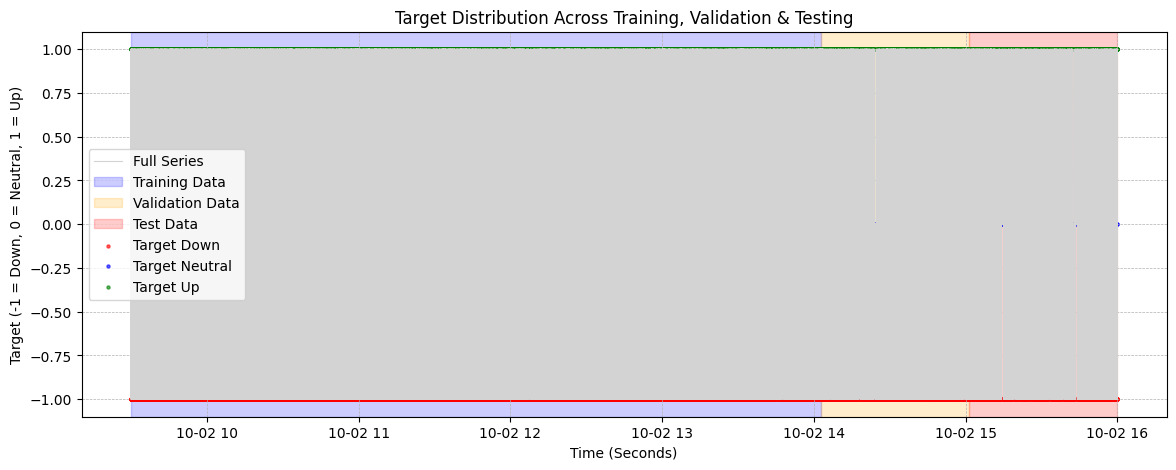

In [90]:
def plot_target_split_with_background(df, train_size, val_size):
    plt.figure(figsize=(14, 5))
    
    # Plot the full target curve in light gray
    plt.plot(df.index, df["Target"], label="Full Series", color="lightgray", linewidth=0.8)

    # Highlight Training, Validation, and Testing Regions
    plt.axvspan(df.index[0], df.index[train_size - 1], color='blue', alpha=0.2, label="Training Data")
    plt.axvspan(df.index[train_size], df.index[train_size + val_size - 1], color='orange', alpha=0.2, label="Validation Data")
    plt.axvspan(df.index[train_size + val_size], df.index[-1], color='red', alpha=0.2, label="Test Data")

    # Scatter plot for target movement (Three classes)
    target_down = df[df["Target"] == -1]
    target_neutral = df[df["Target"] == 0]
    target_up = df[df["Target"] == 1]

    plt.scatter(target_down.index, target_down["Target"], color="red", label="Target Down", s=5, alpha=0.6)
    plt.scatter(target_neutral.index, target_neutral["Target"], color="blue", label="Target Neutral", s=5, alpha=0.6)
    plt.scatter(target_up.index, target_up["Target"], color="green", label="Target Up", s=5, alpha=0.6)

    plt.xlabel("Time (Seconds)")
    plt.ylabel("Target (-1 = Down, 0 = Neutral, 1 = Up)")
    plt.title("Target Distribution Across Training, Validation & Testing")
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.show()

# Plot the target split with background
plot_target_split_with_background(data_hft, train_size, val_size)

In [91]:
# Data scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Initialize scalers
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform on training data
train_standard_scaled = standard_scaler.fit_transform(train_df[standard_features])
train_minmax_scaled = minmax_scaler.fit_transform(train_df[minmax_features])

# Transform validation and test data
val_standard_scaled = standard_scaler.transform(val_df[standard_features])
val_minmax_scaled = minmax_scaler.transform(val_df[minmax_features])

test_standard_scaled = standard_scaler.transform(test_df[standard_features])
test_minmax_scaled = minmax_scaler.transform(test_df[minmax_features])

train_series_scaled = np.hstack((train_standard_scaled, train_minmax_scaled))
val_series_scaled = np.hstack((val_standard_scaled, val_minmax_scaled))
test_series_scaled = np.hstack((test_standard_scaled, test_minmax_scaled))

In [92]:
# Custom PyTorch Dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets, look_back):
        self.data = data
        self.targets = targets
        self.look_back = look_back
    
    def __len__(self):
        return len(self.data) - self.look_back
    
    def __getitem__(self, index):
        x = self.data[index : index + self.look_back]
        y = self.targets[index + self.look_back]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long) 

In [93]:
# Create dataset and dataloaders
train_dataset = TimeSeriesDataset(train_series_scaled, train_df[prediction_column].values, look_back)
val_dataset = TimeSeriesDataset(val_series_scaled, val_df[prediction_column].values, look_back)
test_dataset = TimeSeriesDataset(test_series_scaled, test_df[prediction_column].values, look_back)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

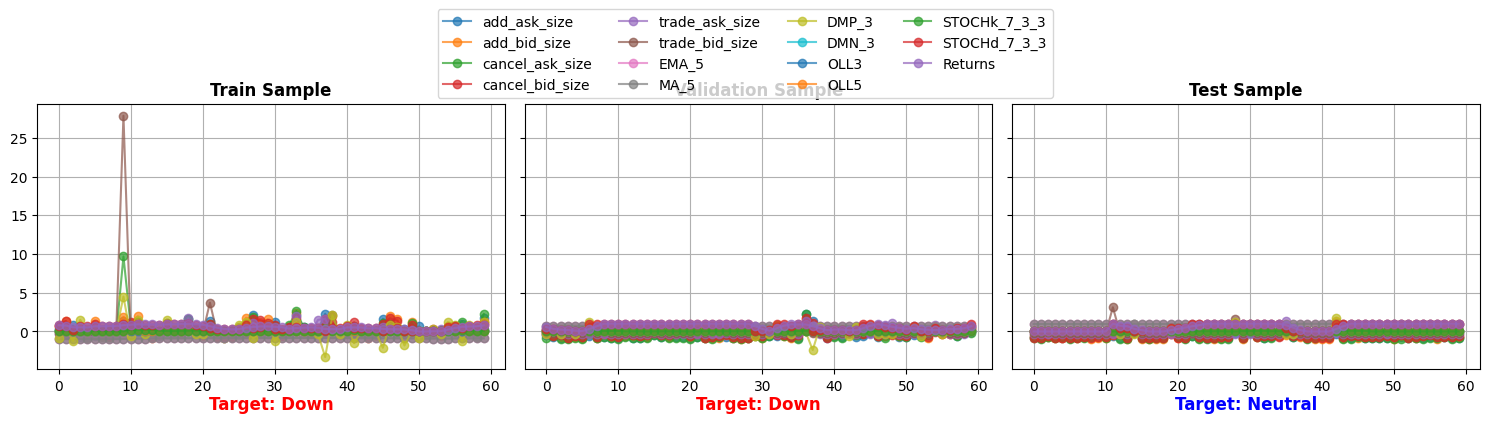

In [94]:
def plot_samples(datasets, titles, feature_names):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

    # Define colors for the three classes
    target_colors = {-1: "red", 0: "blue", 1: "green"}
    target_labels = {-1: "Down", 0: "Neutral", 1: "Up"}

    for i, (dataset, title) in enumerate(zip(datasets, titles)):
        sample_idx = np.random.randint(len(dataset))
        sample, target = dataset[sample_idx]
        sample = sample.numpy().T  # Transpose for feature-wise plotting

        for j, feature in enumerate(feature_names):
            axes[i].plot(sample[j], marker="o", linestyle="-", alpha=0.7, label=feature)

        # Get target class as integer
        target_value = int(target.item())

        # Determine color and text for target
        target_color = target_colors.get(target_value, "black")
        target_text = f"Target: {target_labels.get(target_value, 'Unknown')}"

        # Set title and target annotation
        axes[i].set_title(title, fontsize=12, fontweight="bold")
        axes[i].text(
            0.5, -0.15, target_text,
            fontsize=12, fontweight="bold", color=target_color,
            ha="center", transform=axes[i].transAxes
        )

        axes[i].grid(True)

    # Shared legend with flexible layout
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles, labels, loc="upper center",
        bbox_to_anchor=(0.5, 1.08), ncol=min(len(feature_names), 4),
        fontsize=10, frameon=True
    )

    plt.tight_layout(rect=[0, 0, 1, 0.92]) 
    plt.show()

# Call the function with datasets and feature names
plot_samples([train_dataset, val_dataset, test_dataset], 
             ["Train Sample", "Validation Sample", "Test Sample"], 
             features)


In [95]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = nn.BCELoss(reduction='none')

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        prob = inputs
        focal_weight = self.alpha * (1 - prob) ** self.gamma + (1 - self.alpha) * prob ** self.gamma
        loss = focal_weight * bce_loss
        
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

In [ ]:
# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 3)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        x = self.fc(lstm_out[:, -1, :])  # Get last timestep output
        return self.softmax(x)

# Initialize model, loss function, and optimizer
model = LSTMModel(input_size=len(features))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.0)
# optimizer = optim.Adam(model.parameters(), lr=0.005)


Training started...
Epoch 1/6 - Start time: 19:26:12
  Batch 0: Cumulative time elapsed: 0.03s
  Batch 500: Cumulative time elapsed: 14.52s
  Batch 1000: Cumulative time elapsed: 30.81s
  Batch 1500: Cumulative time elapsed: 47.40s
Epoch 1 completed in 55.89s
  Train Loss: 1.0621, Train Acc: 0.4252
  Val Loss: 0.9579, Val Acc: 0.5861

Epoch 2/6 - Start time: 19:27:08
  Batch 0: Cumulative time elapsed: 0.04s
  Batch 500: Cumulative time elapsed: 16.39s
  Batch 1000: Cumulative time elapsed: 33.59s
  Batch 1500: Cumulative time elapsed: 52.07s
Epoch 2 completed in 62.29s
  Train Loss: 1.0538, Train Acc: 0.4369
  Val Loss: 0.9565, Val Acc: 0.5861

Epoch 3/6 - Start time: 19:28:10
  Batch 0: Cumulative time elapsed: 0.03s
  Batch 500: Cumulative time elapsed: 17.13s
  Batch 1000: Cumulative time elapsed: 35.29s
  Batch 1500: Cumulative time elapsed: 54.65s
Epoch 3 completed in 63.30s
  Train Loss: 1.0532, Train Acc: 0.4357
  Val Loss: 0.9650, Val Acc: 0.5867

Epoch 4/6 - Start time: 19:29

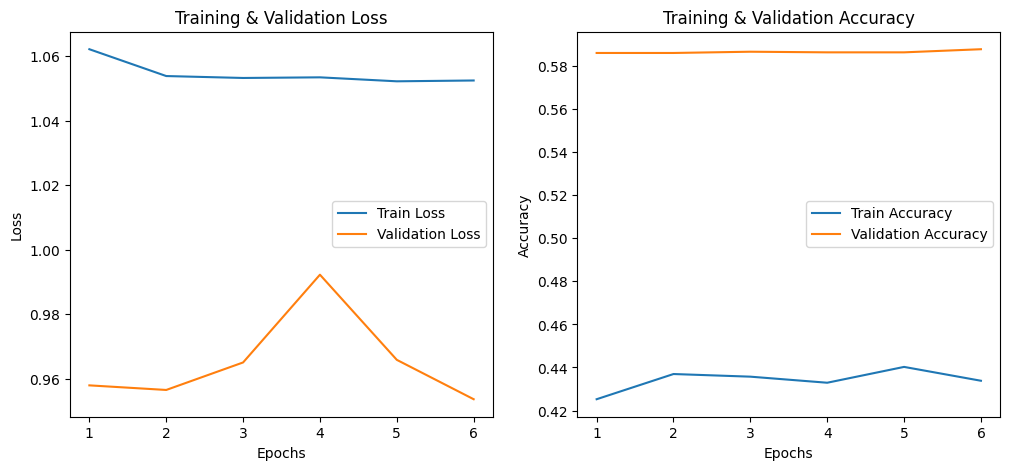

In [ ]:
def train_model(model, train_loader, val_loader, epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    print("Training started...")
    start_time = time.time()

    for epoch in range(epochs):
        epoch_start = time.time()
        print(f"Epoch {epoch + 1}/{epochs} - Start time: {time.strftime('%H:%M:%S')}")
        
        model.train()
        train_loss = 0.0
        correct_train, total_train = 0, 0

        for batch_idx, (inputs, targets) in enumerate(train_loader):

            optimizer.zero_grad()
            outputs = model(inputs)

            targets_shifted = targets + 1

            loss = criterion(outputs, targets_shifted)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)
            
            correct_train += (predicted == targets_shifted).sum().item()
            total_train += targets.size(0)

            if batch_idx % 500 == 0:
                print(f"  Batch {batch_idx}: Cumulative time elapsed: {time.time() - epoch_start:.2f}s")

        train_acc = correct_train / total_train
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_acc)

        model.eval()
        val_loss = 0.0
        correct_val, total_val = 0, 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)

                targets_shifted = targets + 1

                loss = criterion(outputs, targets_shifted)

                val_loss += loss.item()
                predicted = torch.argmax(outputs, dim=1)

                correct_val += (predicted == targets_shifted).sum().item()
                total_val += targets.size(0)

        val_acc = correct_val / total_val
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_acc)
        
        print(f"Epoch {epoch+1} completed in {time.time() - epoch_start:.2f}s")
        print(f"  Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.4f}")
        print(f"  Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.4f}\n")
    
    print(f"Training completed in {time.time() - start_time:.2f}s\n")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()

    plt.show()
    
    return model

# Train model
model = train_model(model, train_loader, val_loader, epochs=epochs)

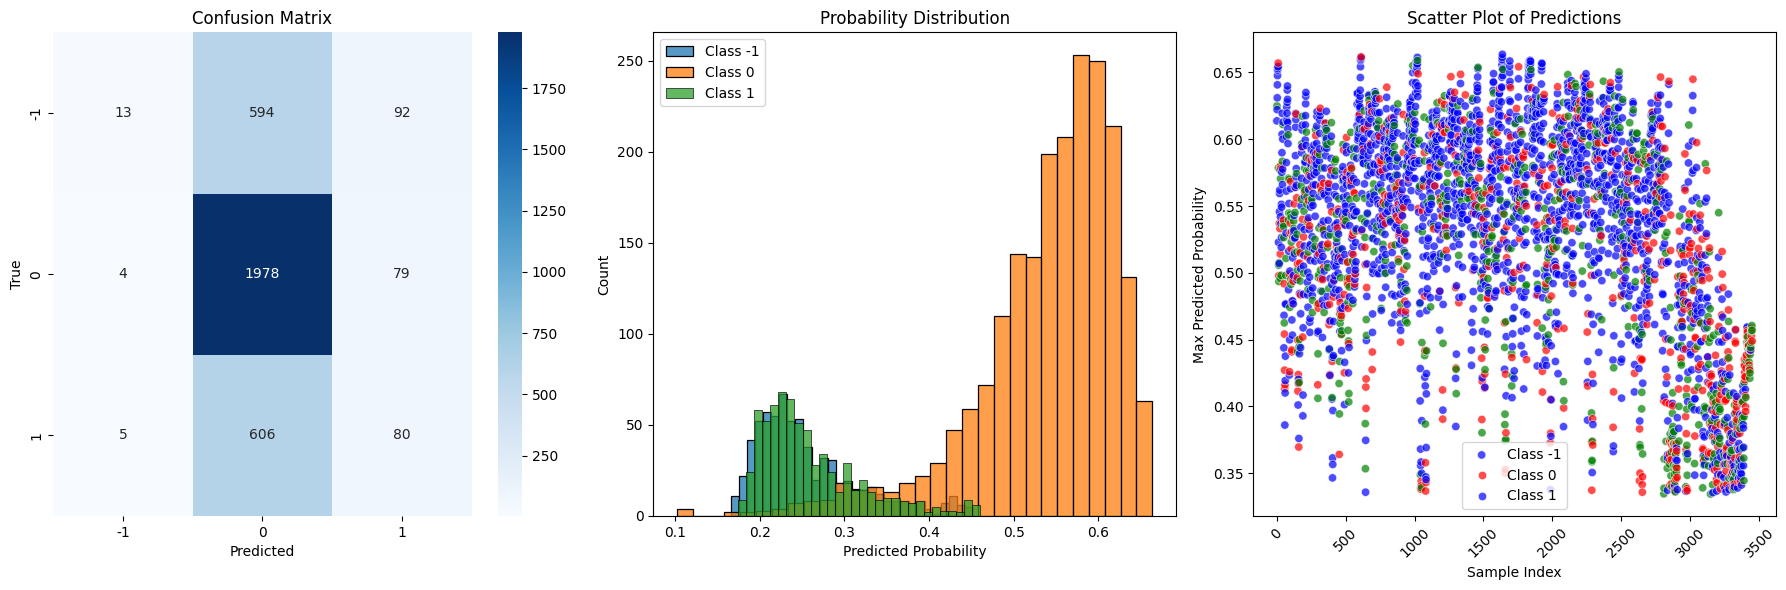

Accuracy: 0.6001
              precision    recall  f1-score   support

          -1       0.59      0.02      0.04       699
           0       0.62      0.96      0.76      2061
           1       0.32      0.12      0.17       691

    accuracy                           0.60      3451
   macro avg       0.51      0.36      0.32      3451
weighted avg       0.56      0.60      0.49      3451



In [98]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def evaluate_model(model, test_loader):
    """Evaluates the model on a test set and plots relevant metrics."""
    model.eval()
    y_true, y_pred, log_probabilities = [], [], []

    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            log_probabilities.extend(outputs.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred) - 1
    log_probabilities = np.array(log_probabilities)
    probabilities = np.exp(log_probabilities)

    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))


    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0], xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
    axes[0].set_title("Confusion Matrix")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("True")

    # Histogram of Predicted Probabilities
    for i, class_label in enumerate(["Class -1", "Class 0", "Class 1"]):
        label = i - 1
        sns.histplot(probabilities[y_true == label][:, i], bins=30, label=class_label, ax=axes[1])
    axes[1].set_title("Probability Distribution")
    axes[1].set_xlabel("Predicted Probability")
    axes[1].legend()

    # Scatter Plot of Predictions
    sns.scatterplot(x=np.arange(len(probabilities)), y=probabilities.max(axis=1), hue=y_true, palette={-1: "red", 0: "blue", 1: "green"}, alpha=0.7, ax=axes[2])
    axes[2].set_title("Scatter Plot of Predictions")
    axes[2].set_xlabel("Sample Index")
    axes[2].set_ylabel("Max Predicted Probability")
    axes[2].legend(["Class -1", "Class 0", "Class 1"])
    axes[2].tick_params(axis="x", rotation=45)

    plt.tight_layout()
    plt.show()

    # Print Evaluation Metrics
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(classification_report(y_true, y_pred, zero_division=0))

    return y_true, y_pred, log_probabilities

y_true, y_pred, log_probabilities = evaluate_model(model, test_loader)

Baseline Strategy Accuracy: 0.5139


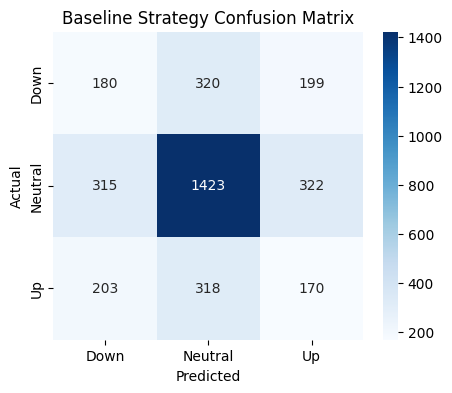

In [99]:
def baseline_strategy(df):
    """Predicts tomorrow's target based on the sign and magnitude of today's return."""
    targets_shifted = df["Target"].shift(1)  # Use today's target to predict tomorrow's target
    baseline_preds = targets_shifted.fillna(1).astype(int)  # Fill NaN with neutral (1) and convert to int
    
    return baseline_preds[1:], df["Target"][1:]  # Align predictions with actual targets

# Assuming test_df is your test DataFrame and look_back is defined
# Evaluate Baseline Strategy
baseline_preds, baseline_targets = baseline_strategy(test_df.iloc[look_back:, :])
baseline_acc = accuracy_score(baseline_targets, baseline_preds)
print(f"Baseline Strategy Accuracy: {baseline_acc:.4f}")

# Confusion Matrix for Baseline Strategy
conf_matrix = confusion_matrix(baseline_targets, baseline_preds, labels=[-1, 0, 1])

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Down", "Neutral", "Up"], 
            yticklabels=["Down", "Neutral", "Up"])

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Baseline Strategy Confusion Matrix")
plt.show()